# PARSE TELEGRAM
#### Here we connect to telegram and download data from specified group and from specified date till now
#### You need to have `config.ini` file with telegram app credentials (get ones at [Telegram development API tools](https://my.telegram.org/))

In [566]:
import configparser
import json
import asyncio
from datetime import date, datetime
from pytz import timezone

from telethon import TelegramClient
from telethon.errors import SessionPasswordNeededError
from telethon.tl.functions.channels import GetParticipantsRequest
from telethon.tl.types import ChannelParticipantsSearch
from telethon.tl.functions.messages import (GetHistoryRequest)
from telethon.tl.types import (
    PeerChannel
)
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timezone, timedelta
%matplotlib inline

In [522]:
async def collect_telegram_data(chat_URL = 'https://t.me/jksimvol', first_date = '2020-05-10', 
                                total_count_limit = 5000, save_media = True):
    '''
    Collects telegram data
    You shall have 'config.ini' file in script folder with telegram app credentials
    
    chat_URL - string of chat URL (e.g. 'https://t.me/jksimvol')
    first_date - which date to collect messages from up to now in 'YYYY-MM-DD' string format
    total_count_limit - hard limit for messages to collect
    save_media - if True, saves photos, videos and files to "media" folder
    
    returns 4 pandas dataframes: users table, messages, web pages and polls
    '''
    # CREATE SUBFOLDERS
    print('\t ## CREATING SUBFOLDERS ##')
    current_time = (str(pd.to_datetime(datetime.now()))[:-10]).replace('-','_').replace(':','_')
    dirname = '%s__%s'%(chat_URL.split('/')[-1],current_time)
    os.mkdir(dirname)
    os.mkdir('./%s/media'%dirname)
    os.mkdir('./%s/tables'%dirname)
    
    # CONNECT TO TELEGRAM -- you need to have "config.ini" file in script folder with app credentials
    print('\n\t ## CONNECTING TO TELEGRAM ##')
    ## Reading Configs
    config = configparser.ConfigParser()
    config.read("config.ini")

    ## Setting configuration values
    api_id = config['Telegram']['api_id']
    api_hash = str(config['Telegram']['api_hash'])
    phone = config['Telegram']['phone']
    username = config['Telegram']['username']
    
    ## Create client
    client = TelegramClient(username, api_id, api_hash)
    
    ## Start client
    await client.start()
    if await client.is_user_authorized() == False:
        await client.send_code_request(phone)
        try:
            await client.sign_in(phone, input('Enter the code: '))
        except SessionPasswordNeededError:
            await client.sign_in(password=input('Password: '))
            
    ## Enter channel
    my_channel = await client.get_entity(chat_URL)
        
    # GET USERS
    print('\n\t ## COLLECTING USERS ##')
    offset = 0
    limit = 100
    all_participants = []

    while True:
        participants = await client(GetParticipantsRequest(
            my_channel, ChannelParticipantsSearch(''), offset, limit,
            hash=0
        ))
        if not participants.users:
            break
        all_participants.extend(participants.users)
        offset += len(participants.users)

    all_user_details = []
    for participant in all_participants:
        all_user_details.append(
            {"id": participant.id, "first_name": participant.first_name, "last_name": participant.last_name,
             "user": participant.username, "phone": participant.phone, "is_bot": participant.bot})
    
    users_df = pd.DataFrame(all_user_details).rename(columns={'id':'user_id'})
    users_df['user_name'] = (np.where(users_df.first_name.isnull(),'',users_df.first_name.astype(str)+"_") + 
                             np.where(users_df.last_name.isnull(),'',users_df.last_name.astype(str)+"_") +
                             users_df.user_id.apply(lambda x: '(%s)'%str(x)))
    users_df.drop(['first_name','last_name','phone','user'], axis=1, inplace=True)
    print('%i users collected!'%users_df.shape[0])
    users_df.to_pickle('./%s/tables/users_df.pkl'%dirname)
    
    # GET MESSAGES
    print('\n\t ## COLLECTING MESSAGES ##')
    offset_id = 0
    limit = 100
    all_messages = []
    total_messages = 0
    first_dt = pd.to_datetime(first_date)

    while True:
        print("Current Offset ID is:", offset_id, "; Total Messages:", total_messages)
        history = await client(GetHistoryRequest(
            peer=my_channel,
            offset_id=offset_id,
            offset_date=None,
            add_offset=0,
            limit=limit,
            max_id=0,
            min_id=0,
            hash=0
        ))
        if not history.messages:
            break
        messages = history.messages
        date_break = False
        for message in messages:
            m = message.to_dict()
            if 'media' in m and save_media:
                if m['media'] != None:
                    if m['media']['_'] in ['MessageMediaPhoto','MessageMediaDocument']:
                        await client.download_media(message, './%s/media/%s'%(dirname,message.id))
            if pd.to_datetime((message.date + timedelta(hours=3)).date()) < first_dt:
                date_break = True
            all_messages.append(m)
        if date_break:
            break
        offset_id = messages[len(messages) - 1].id
        total_messages = len(all_messages)
        if total_count_limit != 0 and total_messages >= total_count_limit:
            break
    
    to_keep = ['id','_','from_id','date','fwd_from','media','message','reply_to_msg_id','views']
    msg = pd.DataFrame(all_messages)[to_keep].rename(columns={'id':'msg_id','from_id':'user_id','_':'msg_type'})
    msg = msg.merge(users_df, how='left').drop('user_id', axis=1)
    msg['msg_type'] = np.where(msg['msg_type']=='MessageService','new_user','normal')
    msg['date'] = msg.date.apply(lambda x: x.astimezone(timezone('Europe/Moscow')))
    msg['dates_to_keep'] = msg.date.apply(lambda x: pd.to_datetime(x.date())>=first_dt)
    msg = msg[msg.dates_to_keep].drop('dates_to_keep',axis=1)
    
    media_files = msg.loc[msg.media.isnull()==False,'media'].tolist()
    media_msg_ids = msg.loc[msg.media.isnull()==False,'msg_id'].tolist()
    media_df = pd.DataFrame(media_files)
    media_df['msg_id'] = media_msg_ids
    media_df['type'] = media_df._.str.replace('MessageMedia', '')
    media_df.drop(['_','document','photo','ttl_seconds'], axis=1, inplace=True)
    
    msg = msg.merge(media_df[['msg_id','type']].copy().rename(columns={'type':'media_type'}), how='left').drop('media', axis=1)
    print('%i messages collected!'%msg.shape[0])
    print('%i users joined!'%msg[msg.msg_type=='new_user'].shape[0])
    msg.to_pickle('./%s/tables/msg_df.pkl'%dirname)
    
    # CREATE MEDIA SUBTABLES
    print('\n\t ## CREATING MEDIA SUBRABLES ##')
    ## Web Pages
    web_pages = media_df.loc[media_df.type=='WebPage',['msg_id','webpage']]
    for new_col in ['url','type','title','description']:
        web_pages[new_col] = np.nan
        for i in web_pages.index:
            if new_col in web_pages.loc[i,'webpage']:
                web_pages.loc[i,new_col] = web_pages.loc[i,'webpage'][new_col]
    web_pages.drop('webpage', axis=1, inplace=True)
    web_pages.to_pickle('./%s/tables/webpages.pkl'%dirname)
    
    ## Polls
    polls = media_df.loc[media_df.type=='Poll',['msg_id','poll','results']]
    for new_col in ['question','variants','highest','share','total_voted','closed','close_date']:
        polls[new_col] = np.nan
    for i in polls.index:
        if 'question' in polls.loc[i,'poll']:
            polls.loc[i,'question'] = polls.loc[i,'poll']['question']
        if 'answers' in polls.loc[i,'poll']:
            alist = []
            for a in polls.loc[i,'poll']['answers']:
                alist.append(a['text'])
            polls.loc[i,'variants'] = str(alist)
        polls.loc[i,'closed'] = polls.loc[i,'poll']['closed']
        polls.loc[i,'close_date'] = polls.loc[i,'poll']['close_date']

        if polls.loc[i,'results'] != None and pd.Series(polls.loc[i,'results']).isnull()[0] != True:
            total_voted = polls.loc[i,'results']['total_voters']
            for res in polls.loc[i,'results']['results']:
                v = 0
                if res['chosen']:
                    winner_voted = res['voters']
                    winner = alist[v]
                    break
                v+=1
            polls.loc[i,'highest'] = winner
            polls.loc[i,'total_voted'] = int(total_voted)
            polls.loc[i,'share'] = winner_voted / total_voted
    polls.drop(['poll','results'],axis=1, inplace=True)
    polls.to_pickle('./%s/tables/polls.pkl'%dirname)
    print('\n\t ## DATA UPLOAD DONE SUCCESSFULLY ##')
    return users_df, msg, web_pages, polls

In [ ]:
users_df, msg, web_pages, polls = collect_telegram_data(chat_URL = 'https://t.me/jksimvol', 
                                                        first_date = '2020-05-10', 
                                                        total_count_limit = 5000, 
                                                        save_media = True)

## ANALYTICS (not required)

In [543]:
msg.sample(5).T

,893,1935,90,2778,2897
msg_id,78652,77586,79478,76725,76589
msg_type,normal,normal,normal,normal,normal
date,2020-05-17 07:22:33+03:00,2020-05-14 10:06:31+03:00,2020-05-20 13:39:20+03:00,2020-05-10 23:56:54+03:00,2020-05-10 13:43:00+03:00
fwd_from,None,None,None,None,None
message,в,Силой заставить не могут?,"Нет, такого нет и паспортистку это раздражает,...","А может, поэтому толпа вновь прибывших молчит? 🤔","Гражданин , всего хорошего 👋"
reply_to_msg_id,NaN,77585,NaN,NaN,76586
views,NaN,NaN,NaN,NaN,NaN
is_bot,False,False,False,False,False
user_name,Владислав_(1237127126),Николай_Владимирович_(510863780),Anastasia_Tanenbaum_(262673009),Fainka_(343553091),Anton_B_(1112027755)
media_type,NaN,NaN,NaN,NaN,NaN


In [538]:
temp = msg.loc[msg.msg_type=='normal',['message','user_name']].copy()
temp['len'] = temp.message.astype(str).str.len()
temp = temp.groupby('user_name').len.agg(['sum','count']).reset_index()
temp['avg'] = temp['sum'] / temp['count']
display(temp.drop(['count','avg'],axis=1).sort_values('sum',ascending=False).head(5).style.set_caption('Top-5 by letters'))
display(temp.drop(['sum','avg'],axis=1).sort_values('count',ascending=False).head(5).style.set_caption('Top-5 by n messages'))
display(temp[temp['count']>=10].drop(['sum','count'],axis=1).sort_values('avg',ascending=False)
        .head(5).style.set_caption('Top-5 by avg length (>=10 messages)'))

,user_name,sum
45,Greatmover_(197666336),18459
137,Роман_Романофф_(663496404),17669
17,Anna_Sveshnikova_(340148348),17638
39,Fainka_(343553091),14104
58,Lolli_(817793736),10652


,user_name,count
39,Fainka_(343553091),248
134,Николай_Владимирович_(510863780),203
137,Роман_Романофф_(663496404),166
58,Lolli_(817793736),148
45,Greatmover_(197666336),115


,user_name,avg
88,Stolz_(441638753),315.583
43,Georgy_Demchenko_(136234443),213.867
17,Anna_Sveshnikova_(340148348),178.162
45,Greatmover_(197666336),160.513
42,Georgy M._(286408827),148.723


In [583]:
msg[msg.media_type=='Photo'].user_name.value_counts().reset_index().head(5).style.set_caption('Who showed more photos')

,index,user_name
0,Марина_(714323391),9
1,Платоныч_(1263094624),9
2,Владимир_Мартиросян_(224914911),8
3,Lolli_(817793736),6
4,Николай_Владимирович_(510863780),5


In [596]:
most_replied = (msg[~msg.reply_to_msg_id.isnull()].groupby('reply_to_msg_id').size().reset_index()
                .sort_values(0,ascending=False).rename(columns={0:'n_replies','reply_to_msg_id':'msg_id'}).head(5)
                .merge(msg[['msg_id','message','user_name']],how='left'))
print('\t\t ### MOST REPLIED_TO MESSAGES: ###\n')
for i in most_replied.index:
    print('%i replies\tUser: %s'%(most_replied.loc[i,'n_replies'],most_replied.loc[i,'user_name']))
    print(most_replied.loc[i,'message'],'\n')

		 ### MOST REPLIED_TO MESSAGES: ###

8 replies	User: Александра_Ян_(576951018)
Давайте возьмём этого адвоката на весь комплекс Свободы. Ну или отдельно домами. 

7 replies	User: Кирилл_(113868797)
Доброго вечера Уважаемые жители. Благодарю Вас за добрые слова, одновременно прошу прощения за те проблемы которые были и у сравнительно небольшого количества собственников еще остаются в Ваших квартирах. Комплекс огромен и довести до ума его сразу сложно, особенно без должного подхвата эксплуатацией. В СМАРТе потенциала в разы больше чем в его предшественнике, а Ваша воля и энергия даст необходимую мотивацию и большое и сложное хозяйство будет отлажено окончательно. Хочу так же поблагодарить Вас за активность. Сообщить что проблема с шумами вентиляции высотных корпусов, доставляющая неудобства жителям высоток признана производителем вентустановок и в конструкцию в ближайшее время будут внесены виброизоляторы. 

6 replies	User: nan
Добрый день, рассматриваю для покупки данный ЖК. По поводу б

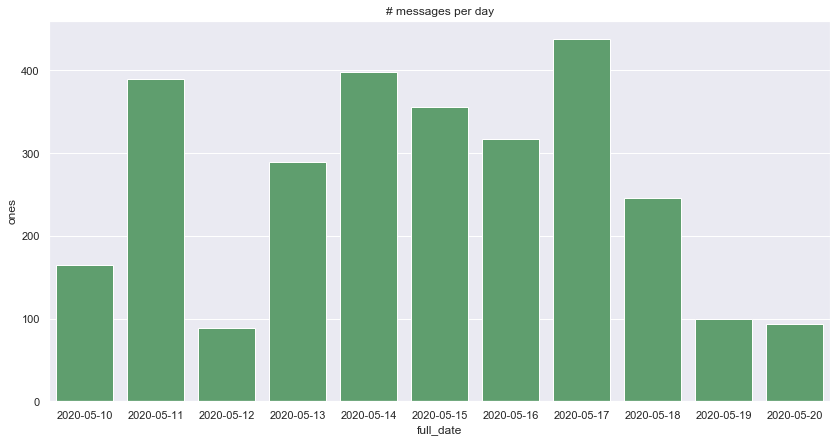

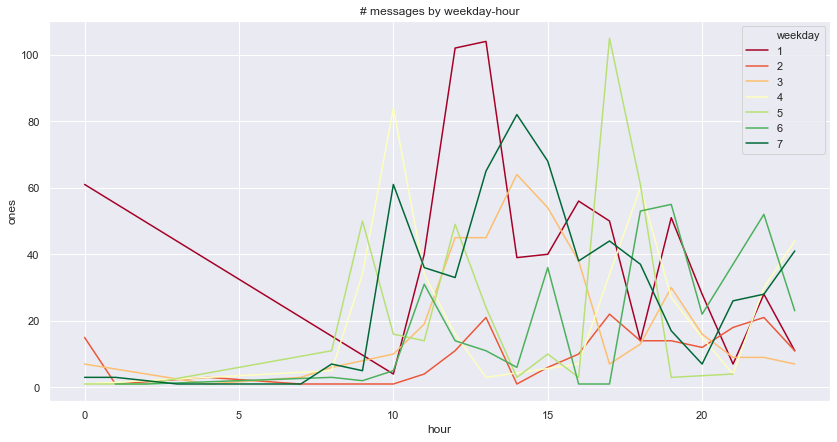

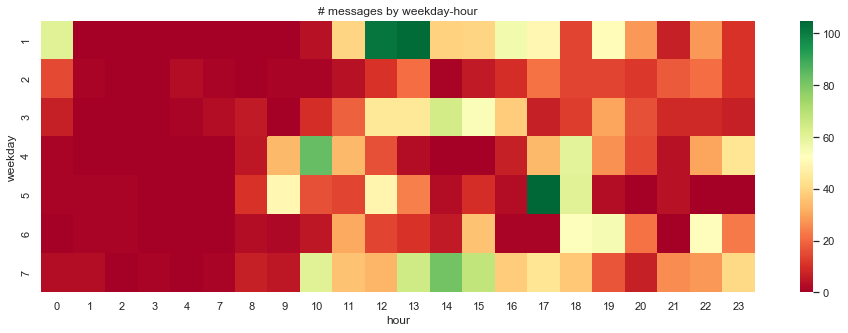

In [597]:
temp = msg.loc[msg.msg_type=='normal',['date','user_name']].copy()
temp['weekday'] = temp.date.dt.weekday + 1
temp['hour'] = temp.date.dt.hour
temp['ones'] = 1
temp['full_date'] = temp.date.dt.date

sns.set(rc={'figure.figsize':(14,7)})
sns.barplot(data=temp.groupby('full_date').ones.sum().reset_index(), x='full_date', y='ones', color='g')
plt.title('# messages per day')
plt.show()

sns.lineplot(data=temp.groupby(['weekday','hour']).ones.sum().reset_index(), 
             x='hour', y='ones', hue='weekday', palette='RdYlGn', legend='full')
plt.title('# messages by weekday-hour')
plt.show()

sns.set(rc={'figure.figsize':(16,5)})
sns.heatmap(pd.pivot_table(temp, index='weekday', columns='hour', values='ones',aggfunc='sum').fillna(0), cmap='RdYlGn')
plt.title('# messages by weekday-hour')
plt.show();